In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-06-22 18:53:16,755 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:16,757 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:16,759 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:16,760 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:16,761 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:16,762 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:16,766 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/de

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-06-22 18:53:17,316 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:17,372 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:17,373 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:17,374 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:17,376 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:17,983 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:18,052 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,053 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,054 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:18,055 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,056 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,056 - settings - Setting database.pa

In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-06-22 18:53:18,936 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,938 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,939 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:18,941 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:19,659 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Getting the Results of the Validation

In [126]:
minnie.AutoProofreadValidationScore6()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,270.19864672128745,=BLOB=,=BLOB=,3,167,4,4,0.42857142857142855,0.42857142857142855,0.42857142857142855,5280,7,39,4,0.9926677946982515,0.9992429977289932,0.995944543996982,497.24
88.00,223037,864691136227167569,0.08,0,=BLOB=,63.375728490237755,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3416,3853,0,0.0002594706798131811,1.0,0.0005188067444876783,486.29
88.00,225498,864691135753932237,0.08,0,=BLOB=,71.18613919983486,=BLOB=,=BLOB=,0,77,0,11,nan,0.0,nan,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,132.46
88.00,230236,864691135609687047,0.08,0,=BLOB=,1433.0806255035059,=BLOB=,=BLOB=,34,552,9,16,0.7906976744186046,0.68,0.7311827956989247,1960,22,1,2,0.9994900560938297,0.9989806320081549,0.99923527912312,725.18
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,974,0,6,nan,0.0,nan,2750,2333,3,48,0.9989102796948783,0.9828448892065761,0.9908124662223023,656.5
88.00,258307,864691135293126156,0.08,0,=BLOB=,639.4047428112395,=BLOB=,=BLOB=,7,342,10,63,0.4117647058823529,0.1,0.16091954022988506,2983,7,25,20,0.991688829787234,0.9933399933399933,0.9925137248377973,339.83
88.00,262773,864691136023889209,0.08,0,=BLOB=,188.51223702930997,=BLOB=,=BLOB=,10,46,3,0,0.7692307692307693,1.0,0.8695652173913044,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,106.98
88.00,264870,864691136951664863,0.08,0,=BLOB=,1109.1181076231987,=BLOB=,=BLOB=,28,401,23,4,0.5490196078431373,0.875,0.674698795180723,2008,26,3,33,0.9985082048731975,0.9838314551690348,0.9911154985192497,514.65
88.00,269247,864691135584074360,0.08,0,=BLOB=,1746.9692128082036,=BLOB=,=BLOB=,176,10,4,94,0.9777777777777777,0.6518518518518519,0.7822222222222223,802,0,7,69,0.9913473423980222,0.9207807118254879,0.9547619047619047,480.65
88.00,269380,864691135974639471,0.08,0,=BLOB=,441.8252727785885,=BLOB=,=BLOB=,28,257,4,10,0.875,0.7368421052631579,0.7999999999999999,1863,4,8,3,0.9957242116515232,0.9983922829581994,0.9970564624029972,304.95


In [127]:
training_set = minnie.AutoProofreadValidationSegment.proj(old_segment_id="segment_id").fetch("old_segment_id")
training_set      

array([864691134988386682, 864691135113167769, 864691135212632448,
       864691135212690816, 864691135233108569, 864691135272164113,
       864691135348272855, 864691135382947307, 864691135393964789,
       864691135407289801, 864691135491233631, 864691135501578306,
       864691135510455760, 864691135564655959, 864691135589906955,
       864691135589907979, 864691135645592260, 864691135699269154,
       864691135735426708, 864691135736387732, 864691135737374100,
       864691135740225387, 864691135748568361, 864691135748575017,
       864691135771629819, 864691135785277636, 864691135865518469,
       864691135866394390, 864691135925564174, 864691135945413668,
       864691135974454383, 864691135974454639, 864691135974454895,
       864691136003930314, 864691136008425132, 864691136008573614,
       864691136056340440, 864691136056391384, 864691136099807093,
       864691136105484249, 864691136105491417, 864691136105493209,
       864691136105498585, 864691136134446219, 864691136175008

In [140]:
validation_table_pd = vu.current_validation_df()

In [141]:
import system_utils as su

In [142]:
su.compressed_pickle(validation_table_pd,"validation_table_pd_6_25_adjusted_big_skip_distance_and_short_thick_endnodes")

Saved object at /neuron_mesh_tools/Auto_Proofreading/Validation_Testing/v4_unseen/validation_table_pd_6_25_adjusted_big_skip_distance_and_short_thick_endnodes.pbz2
File size is 35.842499 MB


# On Training Set

Segment Id = 864691134988386682
Postsyn counts:
TP:214481
TN:1143
FP:336
FN:1618
Presyn counts:
TP:1671
TN:10345
FP:361
FN:680


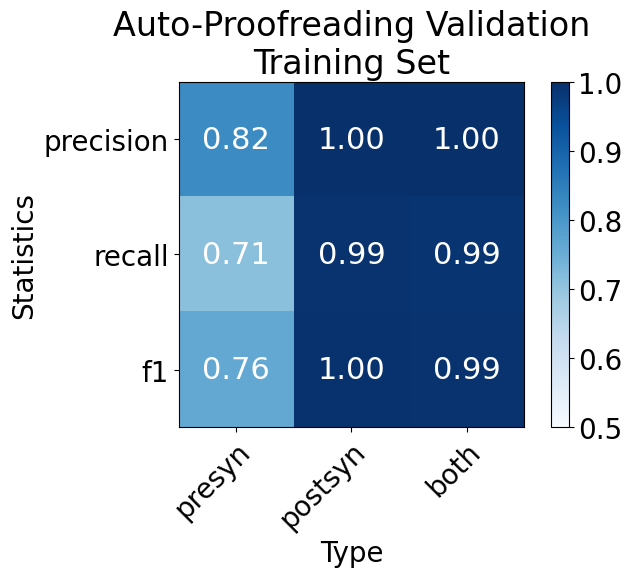

In [143]:
training_df = validation_table_pd[validation_table_pd["old_segment_id"].isin(training_set)]
vu.validation_df_to_score_plot(training_df,
                              title_append = "Training Set")

# With the held out neurons

In [144]:
held_out_df = validation_table_pd[~validation_table_pd["old_segment_id"].isin(training_set)]

Segment Id = 864691134988385914
Postsyn counts:
TP:315581
TN:117181
FP:10505
FN:8452
Presyn counts:
TP:795
TN:16964
FP:252
FN:379


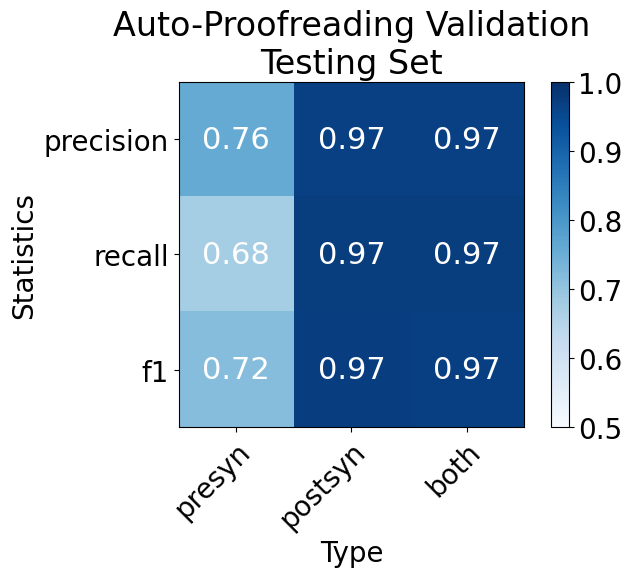

In [145]:
vu.validation_df_to_score_plot(held_out_df,title_append = "Testing Set")

In [146]:
n_somas,n_glia = held_out_df["n_somas"].to_numpy(),held_out_df["n_glia"].to_numpy()

In [147]:
n_somas

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1])

In [148]:
n_glia

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [149]:
len(np.where(n_somas>1)[0])/len(n_somas)

0.3333333333333333

In [150]:
np.sum(n_glia)

4

# Overall Accuracy

Segment Id = 864691134988385914
Postsyn counts:
TP:530062
TN:118324
FP:10841
FN:10070
Presyn counts:
TP:2466
TN:27309
FP:613
FN:1059


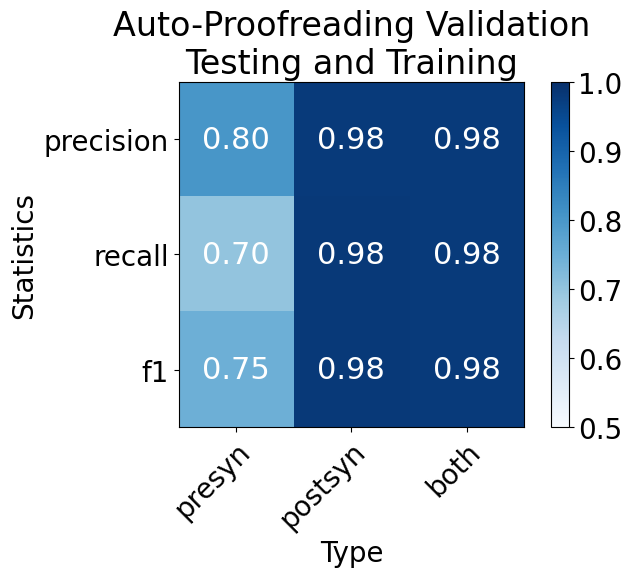

In [151]:
vu.validation_df_to_score_plot(validation_table_pd,
                              title_append = "Testing and Training")

# on the training set

In [ ]:
curr_table2 = ((minnie.AutoProofreadValidationScore5() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table2

In [ ]:
(curr_table2 & dict(segment_id=864691136378815445)).fetch1("decomposition")

In [ ]:
curr_table = ((minnie.AutoProofreadValidationScore4() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table

In [ ]:
seg_ids,pre_recall_v4 = curr_table.fetch("segment_id","pre_recall")
pre_recall_v5 = curr_table2.fetch("pre_recall")

In [ ]:
recall_diff = (pre_recall_v4 - pre_recall_v5)
indices_recall_diff = np.where(recall_diff > 0)[0]
print(recall_diff[indices_recall_diff])
print(seg_ids[indices_recall_diff])

In [ ]:
curr_table2 & dict(segment_id=864691135415666362)

In [ ]:
total_validation_df = vu.table_to_score_plot(curr_table,
                       return_validation_df=True)